In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(), #horizontally flip the image
    transforms.RandomRotation(10), #rotate the image by angle
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.1), #randomly change the brightness, contrast, saturation
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5, 0.5))
])

In [5]:
train_dataset = datasets.Flowers102(root='./data', split="train",transform = transform_train,download=True)

100%|██████████| 345M/345M [00:20<00:00, 17.0MB/s]
100%|██████████| 502/502 [00:00<00:00, 2.07MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 28.1MB/s]


In [6]:
test_dataset = datasets.Flowers102(root='./data', split="val",transform = transform_test,download=True)

In [7]:
indices = torch.randint(len(train_dataset),(5,))
samples = [train_dataset[i] for i in indices]

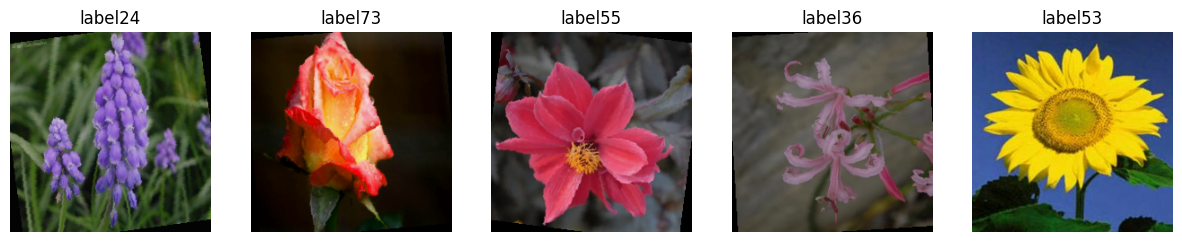

In [9]:
fig, axes = plt.subplots(1,5,figsize=(15,5))
for i, (image,label) in enumerate(samples):
  image = image.numpy().transpose((1,2,0))
  image = (image * 0.5) + 0.5
  axes[i].imshow(image)
  axes[i].set_title(f"label{label}")
  axes[i].axis('off')
plt.show()

In [10]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [11]:
model = models.mobilenet_v2(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features,102)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 221MB/s]


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [14]:
epochs = 3
for epoch in tqdm(range(epochs)):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  scheduler.step()
  print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

 33%|███▎      | 1/3 [00:16<00:32, 16.46s/it]

Epoch 1/3, Loss: 4.564735285937786


 67%|██████▋   | 2/3 [00:33<00:16, 16.88s/it]

Epoch 2/3, Loss: 2.9794500693678856


100%|██████████| 3/3 [00:48<00:00, 16.18s/it]

Epoch 3/3, Loss: 2.0606351234018803


In [15]:
torch.save(model.state_dict(),"mobilenet_flowers102.pth")

In [16]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
  for images, labels in tqdm(test_loader):
    images, labeşs = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs,1)
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


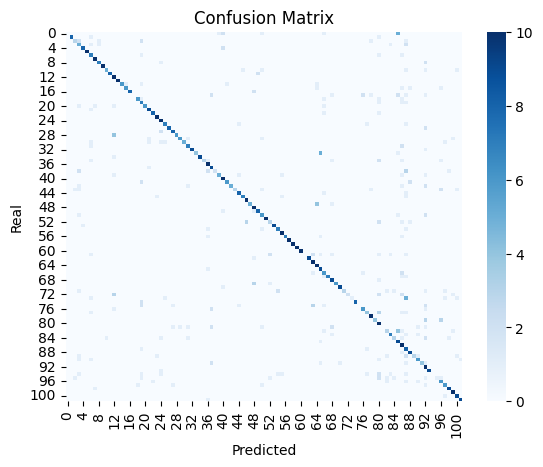

In [17]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure()
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title("Confusion Matrix")
plt.show()

In [18]:
print(classification_report(all_labels,all_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       1.00      0.80      0.89        10
           2       0.60      0.30      0.40        10
           3       0.29      0.50      0.37        10
           4       0.89      0.80      0.84        10
           5       1.00      1.00      1.00        10
           6       0.41      0.70      0.52        10
           7       0.83      1.00      0.91        10
           8       0.78      0.70      0.74        10
           9       1.00      1.00      1.00        10
          10       0.83      0.50      0.62        10
          11       1.00      0.80      0.89        10
          12       0.48      1.00      0.65        10
          13       1.00      1.00      1.00        10
          14       1.00      0.60      0.75        10
          15       0.86      0.60      0.71        10
          16       1.00      0.80      0.89        10
          17       0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
